In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import folium
from folium.plugins import HeatMap as hm
import pgeocode
import json
import datetime as dt
%matplotlib inline

In [3]:
# Loading Dataset
# Dataset: https://data.cityofnewyork.us/Public-Safety/Incidents-Responded-to-by-Fire-Companies/tm6d-hbzd 
fires = pd.read_csv('C:\\Users\\Daiyan\\VisualStudioProjects\\nyc_fires\\files\\fire_data.csv', low_memory=False)
fires

,IM_INCIDENT_KEY,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,HIGHEST_LEVEL_DESC,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,...,ZIP_CODE,BOROUGH_DESC,FLOOR,CO_DETECTOR_PRESENT_DESC,FIRE_ORIGIN_BELOW_GRADE_FLAG,STORY_FIRE_ORIGIN_COUNT,FIRE_SPREAD_DESC,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG
0,55672688,2147,"300 - Rescue, EMS incident, other",01/01/2013 12:00:20 AM,01/01/2013 12:14:23 AM,1.0,01/01/2013 12:20:06 AM,"1 - More than initial alarm, less than Signal 7-5",1186.0,"00 - Action taken, other",...,10454,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55672692,0818,735A - Unwarranted alarm/defective condition o...,01/01/2013 12:00:37 AM,01/01/2013 12:09:03 AM,3.0,01/01/2013 12:30:06 AM,"1 - More than initial alarm, less than Signal 7-5",1769.0,86 - Investigate,...,10036,1 - Manhattan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55672693,9656,"300 - Rescue, EMS incident, other",01/01/2013 12:01:17 AM,01/01/2013 12:04:55 AM,1.0,01/01/2013 12:15:18 AM,"1 - More than initial alarm, less than Signal 7-5",841.0,"00 - Action taken, other",...,11418,5 - Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55672695,7412,412 - Gas leak (natural gas or LPG),01/01/2013 12:02:32 AM,01/01/2013 12:07:48 AM,4.0,01/01/2013 12:40:11 AM,"1 - More than initial alarm, less than Signal 7-5",2259.0,44 - Hazardous materials leak control & contai...,...,11103,5 - Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55672697,4019,735A - Unwarranted alarm/defective condition o...,01/01/2013 12:01:49 AM,01/01/2013 12:06:27 AM,6.0,01/01/2013 12:24:56 AM,"1 - More than initial alarm, less than Signal 7-5",1387.0,86 - Investigate,...,11385,5 - Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518753,63476760,5535,412 - Gas leak (natural gas or LPG),06/30/2018 11:52:35 PM,NaN,NaN,07/01/2018 12:11:36 AM,11 - First Alarm,1141.0,44 - Hazardous materials leak control & contai...,...,11427,5 - Queens,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2518754,63476761,2745,"651 - Smoke scare, odor of smoke",06/30/2018 11:54:13 PM,06/30/2018 11:58:29 PM,3.0,07/01/2018 12:07:50 AM,11 - First Alarm,817.0,"00 - Action taken, other",...,10456,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2518755,63476762,2135,"117 - Commercial Compactor fire, confined to r...",06/30/2018 11:54:08 PM,06/30/2018 11:58:53 PM,5.0,07/01/2018 12:19:16 AM,11 - First Alarm,1508.0,11 - Extinguishment by fire service personnel,...,10454,2 - Bronx,basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2518756,63476763,1021,"300 - Rescue, EMS incident, other",06/30/2018 11:54:44 PM,06/30/2018 11:58:59 PM,1.0,07/01/2018 12:09:29 AM,11 - First Alarm,885.0,"00 - Action taken, other",...,11203,4 - Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
# Dropping unwanted columns
cols=[
    'IM_INCIDENT_KEY', 'HIGHEST_LEVEL_DESC', 'ACTION_TAKEN1_DESC', 'ACTION_TAKEN2_DESC', 'ACTION_TAKEN3_DESC', 
    'PROPERTY_USE_DESC', 'FLOOR', 'CO_DETECTOR_PRESENT_DESC', 'FIRE_ORIGIN_BELOW_GRADE_FLAG', 
    'STORY_FIRE_ORIGIN_COUNT', 'FIRE_SPREAD_DESC', 'DETECTOR_PRESENCE_DESC', 'AES_PRESENCE_DESC', 'STANDPIPE_SYS_PRESENT_FLAG'
    ]
df = fires.drop(cols, axis=1)
df.dropna(inplace=True)

# Dropping unwanted rows that don't contain a fire-related incident
df = df[df['INCIDENT_TYPE_DESC'].str.contains('fire')]

# Creating RESPONSE_TIME and YEAR column
df['ARRIVAL_DATE_TIME'] = pd.to_datetime(df['ARRIVAL_DATE_TIME'])
df['INCIDENT_DATE_TIME'] = pd.to_datetime(df['INCIDENT_DATE_TIME'])
df['RESPONSE_TIME'] = ((df['ARRIVAL_DATE_TIME'] - df['INCIDENT_DATE_TIME']).dt.seconds / 60).round(2)
df['YEAR'] = df['INCIDENT_DATE_TIME'].dt.year

# Creating Latitude/Longitude from Zipcode
nomi = pgeocode.Nominatim('US')
query = nomi.query_postal_code(df['ZIP_CODE'].values)
df['LATITUDE'] = query['latitude']
df['LONGITUDE'] = query['longitude']
df

,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,TOTAL_INCIDENT_DURATION,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,RESPONSE_TIME,YEAR,LATITUDE,LONGITUDE
13,3197,"150 - Outside rubbish fire, other",2013-01-01 00:07:00,2013-01-01 00:11:19,1.0,01/01/2013 12:16:40 AM,580.0,E 183 ST,10458,2 - Bronx,4.32,2013,40.6790,-73.9644
20,2602,"151 - Outside rubbish, trash or waste fire",2013-01-01 00:11:35,2013-01-01 00:15:54,1.0,01/01/2013 12:20:47 AM,552.0,52 ST,11219,4 - Brooklyn,4.32,2013,40.5352,-74.2116
23,1949,"118 - Trash or rubbish fire, contained",2013-01-01 00:15:56,2013-01-01 00:20:17,1.0,01/01/2013 12:25:51 AM,595.0,ELSON CT,10314,3 - Staten Island,4.35,2013,40.7453,-73.8611
26,3078,"151 - Outside rubbish, trash or waste fire",2013-01-01 00:19:28,2013-01-01 00:23:55,1.0,01/01/2013 12:30:28 AM,660.0,KIMBALL ST,11234,4 - Brooklyn,4.45,2013,NaN,NaN
29,3474,142 - Brush or brush-and-grass mixture fire,2013-01-01 00:21:44,2013-01-01 00:25:14,1.0,01/01/2013 12:45:06 AM,1402.0,BAY 34 ST,11214,4 - Brooklyn,3.50,2013,40.6011,-73.9475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518618,1646,"151 - Outside rubbish, trash or waste fire",2018-06-30 22:11:40,2018-06-30 22:17:14,1.0,06/30/2018 10:28:02 PM,982.0,PROSPECT PL,11233,4 - Brooklyn,5.57,2018,NaN,NaN
2518664,430,"113 - Cooking fire, confined to container",2018-06-30 22:43:34,2018-06-30 22:48:24,2.0,06/30/2018 10:54:24 PM,650.0,DUFFIELD ST,11201,4 - Brooklyn,4.83,2018,NaN,NaN
2518722,470,"151 - Outside rubbish, trash or waste fire",2018-06-30 23:27:21,2018-06-30 23:30:01,6.0,06/30/2018 11:55:05 PM,1664.0,E 14 ST,10009,1 - Manhattan,2.67,2018,NaN,NaN
2518750,5110,131 - Passenger vehicle fire,2018-06-30 23:49:05,2018-06-30 23:55:33,2.0,07/01/2018 12:18:03 AM,1738.0,75 PL,11379,5 - Queens,6.47,2018,NaN,NaN


In [88]:
# Separate DataFrame By Year
ovr_2013 = df[df['YEAR'] == 2013]
ovr_2014 = df[df['YEAR'] == 2014]
ovr_2015 = df[df['YEAR'] == 2015]
ovr_2016 = df[df['YEAR'] == 2016]
ovr_2017 = df[df['YEAR'] == 2017]
ovr_2018 = df[df['YEAR'] == 2018]

# Displaying number of reports by boroughs.
df['BOROUGH_DESC'].value_counts()

4 - Brooklyn         55313
1 - Manhattan        41618
2 - Bronx            38908
5 - Queens           38543
3 - Staten Island     9648
Name: BOROUGH_DESC, dtype: int64

In [9]:
# Create the HeatMap
def generate_map(default_loc=[40.7128, -74.0060], zoom=10.5, max_zoom=11, min_zoom=10, tiles='Stamen Terrain'):
    base = folium.Map(location=default_loc, control_scale=True, zoom_start=zoom, max_zoom=max_zoom, min_zoom=min_zoom, tiles=tiles)
    return base

base = generate_map()
hm(data=df[['LATITUDE', 'LONGITUDE']].groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist(), radius=7, max_zoom=10.5).add_to(base)
base

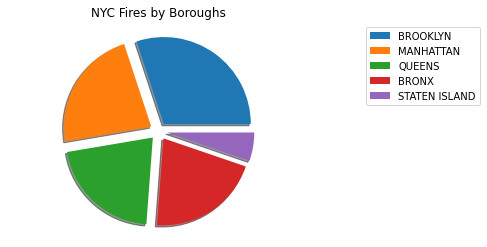

In [10]:
# Pie chart of all boroughs
labels = ['BROOKLYN', 'MANHATTAN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
explode = [0.1, 0.1, 0.1, 0.1, 0.1]
plt.pie(df['BOROUGH_DESC'].value_counts(), labels=labels, explode=explode, shadow=True, textprops={'color' : 'w'})
plt.title('NYC Fires by Boroughs', fontdict={'color': 'black'})
plt.legend(bbox_to_anchor=(2, 1))
plt.show()

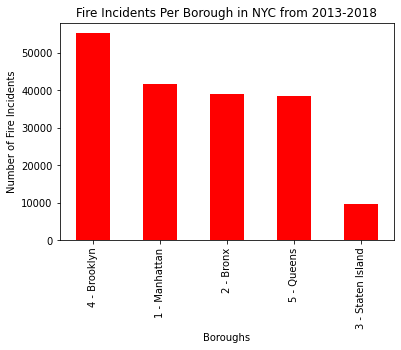

In [11]:
# Histogram
df['BOROUGH_DESC'].value_counts().plot.bar(xlabel='Boroughs', 
ylabel='Number of Fire Incidents', title='Fire Incidents Per Borough in NYC from 2013-2018', color='r')
plt.show()

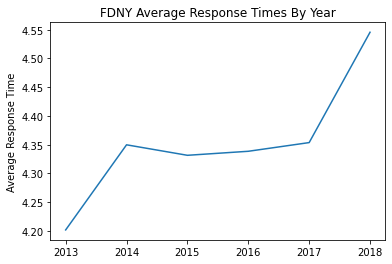

In [95]:
# Average Response Time over Time
x = df.YEAR.value_counts().index.tolist()
x.sort()
y = [ovr_2013['RESPONSE_TIME'].mean(), ovr_2014['RESPONSE_TIME'].mean(), 
ovr_2015['RESPONSE_TIME'].mean(), ovr_2016['RESPONSE_TIME'].mean(), ovr_2017['RESPONSE_TIME'].mean(), ovr_2018['RESPONSE_TIME'].mean()]
plt.plot(x, y)
plt.title('FDNY Average Response Times By Year')
plt.ylabel('Average Response Time')
plt.show()

## BRONX

In [92]:
# Create dataframe - Bronx
bronx_df = df[df['BOROUGH_DESC'] == '2 - Bronx']
nomi = pgeocode.Nominatim('US')
bronx_df.drop(['LATITUDE', 'LONGITUDE'], axis=1)
query = nomi.query_postal_code(bronx_df['ZIP_CODE'].values)
bronx_df['LATITUDE'] = query['latitude']
bronx_df['LONGITUDE'] = query['longitude']
bronx_df.dropna(subset=['LATITUDE'], inplace=True)
bronx_df.dropna(subset=['LONGITUDE'], inplace=True)
bronx_df

C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/3669871179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bronx_df['LATITUDE'] = query['latitude']
C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/3669871179.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bronx_df['LONGITUDE'] = query['longitude']
C:\Users\Daiyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A val

,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,TOTAL_INCIDENT_DURATION,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,RESPONSE_TIME,YEAR,LATITUDE,LONGITUDE
13,3197,"150 - Outside rubbish fire, other",2013-01-01 00:07:00,2013-01-01 00:11:19,1.0,01/01/2013 12:16:40 AM,580.0,E 183 ST,10458,2 - Bronx,4.32,2013,40.8153,-73.9072
36,4067,"151 - Outside rubbish, trash or waste fire",2013-01-01 00:25:27,2013-01-01 00:33:43,1.0,01/01/2013 12:33:59 AM,512.0,SCHURZ AVE,10465,2 - Bronx,8.27,2013,40.8662,-73.9003
121,2538,"113 - Cooking fire, confined to container",2013-01-01 01:23:26,2013-01-01 01:27:05,5.0,01/01/2013 01:37:33 AM,847.0,CLAY AVE,10456,2 - Bronx,3.65,2013,40.9000,-73.8622
167,2707,"151 - Outside rubbish, trash or waste fire",2013-01-01 02:01:05,2013-01-01 02:04:38,1.0,01/01/2013 02:20:58 AM,1193.0,webster ave,10456,2 - Bronx,3.55,2013,40.8316,-73.9099
192,3143,"118 - Trash or rubbish fire, contained",2013-01-01 02:16:55,2013-01-01 02:21:06,6.0,01/01/2013 02:36:23 AM,1168.0,ARTHUR AVE,10457,2 - Bronx,4.18,2013,40.8434,-73.8602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38699,3697,"116 - Fuel burner/boiler malfunction, fire con...",2013-02-04 06:11:28,2013-02-04 06:15:24,4.0,02/04/2013 06:48:38 AM,2230.0,E 227 ST,10466,2 - Bronx,3.93,2013,40.8737,-73.8712
38703,3136,"116 - Fuel burner/boiler malfunction, fire con...",2013-02-04 06:22:17,2013-02-04 06:26:19,6.0,02/04/2013 06:36:17 AM,840.0,BELMONT AVE,10457,2 - Bronx,4.03,2013,40.8261,-73.8196
38823,3334,"113 - Cooking fire, confined to container",2013-02-04 08:57:38,2013-02-04 09:00:10,6.0,02/04/2013 09:10:26 AM,768.0,DECATUR AVE,10458,2 - Bronx,2.53,2013,40.8465,-73.8410
38827,2967,"151 - Outside rubbish, trash or waste fire",2013-02-04 09:02:38,2013-02-04 09:06:29,1.0,02/04/2013 09:11:52 AM,554.0,GRANDCONCOURSE,10457,2 - Bronx,3.85,2013,40.8662,-73.9003


In [14]:
# HeatMap with Markers of Zipcode locations and area frequency - Bronx
bronx = generate_map(default_loc=[40.8448, -73.8648] ,zoom=12, max_zoom=12, min_zoom=12, tiles='Stamen Terrain')
hm(data=bronx_df[['LATITUDE', 'LONGITUDE']].groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist(), radius=7, max_zoom=10.5).add_to(bronx)
for lat, long in zip(bronx_df.LATITUDE, bronx_df.LONGITUDE):
    folium.CircleMarker([lat, long], color='red').add_to(bronx)
bronx

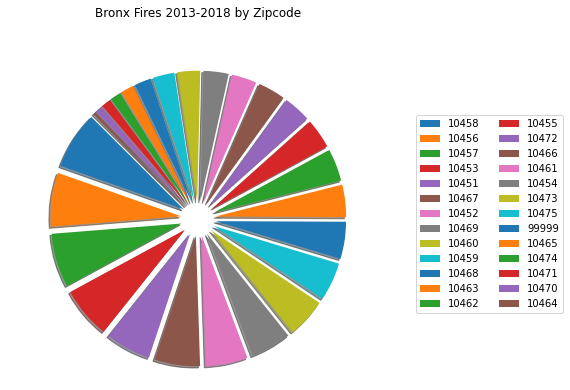

In [15]:
# Pie Chart - Bronx
bronx_labels = bronx_df['ZIP_CODE'].value_counts().index.tolist()
bronx_explode = [0.2] * len(bronx_labels)
plt.pie(bronx_df['ZIP_CODE'].value_counts(), labels=bronx_labels, radius=1.5, shadow=True, 
textprops={'color':'w'}, explode=bronx_explode, startangle=135)
plt.title('Bronx Fires 2013-2018 by Zipcode', color='black', y=1.4)
plt.legend(bronx_labels, bbox_to_anchor=(2.2, 1), ncol=2)
plt.show()

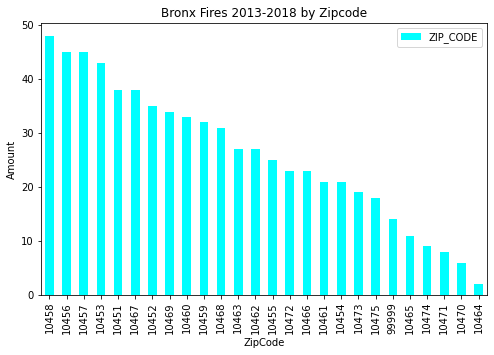

In [16]:
# Bar Graph - Bronx
bronx_df['ZIP_CODE'].value_counts().plot.bar(xlabel='ZipCode', ylabel='Amount', title='Bronx Fires 2013-2018 by Zipcode', color='cyan', figsize=(8,5))
plt.legend()
plt.show()

In [17]:
# Average Response time for Bronx
bronx_average = bronx_df['RESPONSE_TIME'].mean()
bronx_average.round(6)

4.192367

# Brooklyn

In [18]:
# Create dataframe - Brooklyn
brooklyn_df = df[df['BOROUGH_DESC'] == '4 - Brooklyn']
nomi = pgeocode.Nominatim('US')
brooklyn_df.drop(['LATITUDE', 'LONGITUDE'], axis=1)
query = nomi.query_postal_code(brooklyn_df['ZIP_CODE'].values)
brooklyn_df['LATITUDE'] = query['latitude']
brooklyn_df['LONGITUDE'] = query['longitude']
brooklyn_df.dropna(subset=['LATITUDE'], inplace=True)
brooklyn_df.dropna(subset=['LONGITUDE'], inplace=True)
brooklyn_df

C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/630145628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brooklyn_df['LATITUDE'] = query['latitude']
C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/630145628.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brooklyn_df['LONGITUDE'] = query['longitude']
C:\Users\Daiyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A

,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,TOTAL_INCIDENT_DURATION,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,RESPONSE_TIME,LATITUDE,LONGITUDE
20,2602,"151 - Outside rubbish, trash or waste fire",2013-01-01 00:11:35,2013-01-01 00:15:54,1.0,01/01/2013 12:20:47 AM,552.0,52 ST,11219,4 - Brooklyn,4.32,40.6467,-73.9570
26,3078,"151 - Outside rubbish, trash or waste fire",2013-01-01 00:19:28,2013-01-01 00:23:55,1.0,01/01/2013 12:30:28 AM,660.0,KIMBALL ST,11234,4 - Brooklyn,4.45,40.6205,-73.9239
29,3474,142 - Brush or brush-and-grass mixture fire,2013-01-01 00:21:44,2013-01-01 00:25:14,1.0,01/01/2013 12:45:06 AM,1402.0,BAY 34 ST,11214,4 - Brooklyn,3.50,40.6467,-73.9570
40,0030,"151 - Outside rubbish, trash or waste fire",2013-01-01 00:27:02,2013-01-01 00:30:31,1.0,01/01/2013 12:38:08 AM,666.0,JAVA ST,11222,4 - Brooklyn,3.48,40.6251,-74.0303
41,3166,"151 - Outside rubbish, trash or waste fire",2013-01-01 00:27:09,2013-01-01 00:34:00,1.0,01/01/2013 12:37:16 AM,607.0,E 69 ST,11234,4 - Brooklyn,6.85,40.6407,-73.9028
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55063,0644,"113 - Cooking fire, confined to container",2013-02-18 20:15:21,2013-02-18 20:17:35,6.0,02/18/2013 08:36:20 PM,1259.0,EMERSON PL,11205,4 - Brooklyn,2.23,40.6762,-73.8736
55080,2385,111 - Building fire,2013-02-18 20:31:25,2013-02-18 20:36:02,11.0,02/18/2013 10:14:02 PM,6157.0,E 82 ST,11236,4 - Brooklyn,4.62,40.6924,-73.9666
55218,0405,"151 - Outside rubbish, trash or waste fire",2013-02-18 23:38:34,2013-02-18 23:41:06,1.0,02/18/2013 11:45:33 PM,419.0,FLEET WALK,11201,4 - Brooklyn,2.53,40.7012,-73.9436
55237,1674,"113 - Cooking fire, confined to container",2013-02-19 00:08:23,2013-02-19 00:10:20,6.0,02/19/2013 12:17:48 AM,565.0,WATKINS ST,11212,4 - Brooklyn,1.95,40.6505,-73.9349


In [19]:
# HeatMap with Markers of Zipcode locations and area frequency - Brooklyn
brooklyn = generate_map(default_loc=[40.6782, -73.9442] ,zoom=12, max_zoom=12, min_zoom=12, tiles='Stamen Terrain')
hm(data=brooklyn_df[['LATITUDE', 'LONGITUDE']].groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist(), radius=7, max_zoom=10.5).add_to(brooklyn)
for lat, long in zip(brooklyn_df.LATITUDE, brooklyn_df.LONGITUDE):
    folium.CircleMarker([lat, long], color='red').add_to(brooklyn)
brooklyn

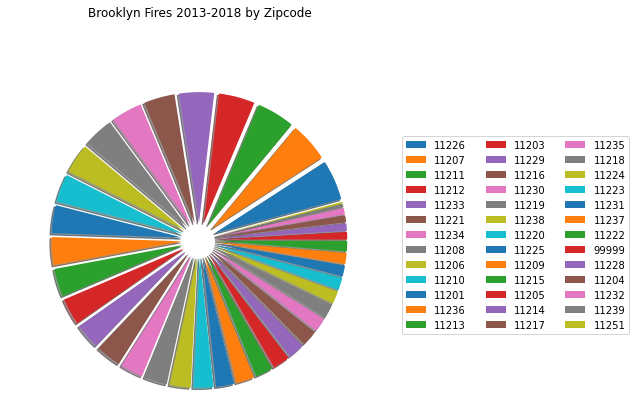

In [20]:
# Pie Chart - Brooklyn
brooklyn_labels = brooklyn_df['ZIP_CODE'].value_counts().index.tolist()
brooklyn_explode = [0.2] * len(brooklyn_labels)
plt.pie(brooklyn_df['ZIP_CODE'].value_counts(), labels=brooklyn_labels, radius=1.5, shadow=True, 
textprops={'color':'w'}, explode=brooklyn_explode, startangle=15)
plt.title('Brooklyn Fires 2013-2018 by Zipcode', color='black', y=1.5)
plt.legend(brooklyn_labels, bbox_to_anchor=(2.5, 1), ncol=3)
plt.show()

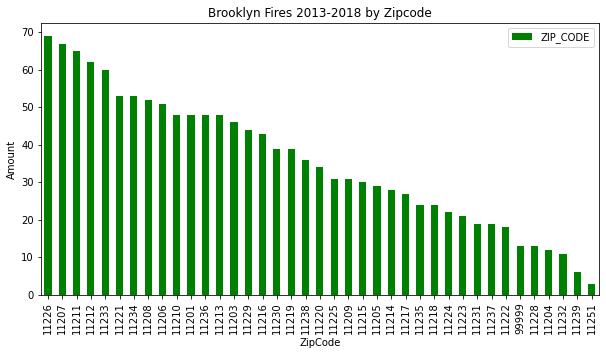

In [21]:
# Bar Graph - Brooklyn
brooklyn_df['ZIP_CODE'].value_counts().plot.bar(xlabel='ZipCode', ylabel='Amount', title='Brooklyn Fires 2013-2018 by Zipcode', color='green', figsize=(10,5))
plt.legend()
plt.show()

In [22]:
# Average Response time for Brooklyn
brooklyn_average = brooklyn_df['RESPONSE_TIME'].mean()
brooklyn_average.round(6)

3.693687

# Manhatten

In [23]:
# Create dataframe - Manhattan
manhattan_df = df[df['BOROUGH_DESC'] == '1 - Manhattan']
nomi = pgeocode.Nominatim('US')
manhattan_df.drop(['LATITUDE', 'LONGITUDE'], axis=1)
query = nomi.query_postal_code(manhattan_df['ZIP_CODE'].values)
manhattan_df['LATITUDE'] = query['latitude']
manhattan_df['LONGITUDE'] = query['longitude']
manhattan_df.dropna(subset=['LATITUDE'], inplace=True)
manhattan_df.dropna(subset=['LONGITUDE'], inplace=True)
manhattan_df

C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/1738454727.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_df['LATITUDE'] = query['latitude']
C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/1738454727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_df['LONGITUDE'] = query['longitude']
C:\Users\Daiyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning

,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,TOTAL_INCIDENT_DURATION,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,RESPONSE_TIME,LATITUDE,LONGITUDE
330,0574,"113 - Cooking fire, confined to container",2013-01-01 04:16:58,2013-01-01 04:20:21,5.0,01/01/2013 04:34:42 AM,1064.0,W 17 ST,10011,1 - Manhattan,3.38,40.7975,-73.9683
361,0218,"151 - Outside rubbish, trash or waste fire",2013-01-01 04:47:08,2013-01-01 04:50:46,6.0,01/01/2013 04:58:48 AM,700.0,RUTGERS ST,99999,1 - Manhattan,3.63,40.7975,-73.9683
374,0385,"113 - Cooking fire, confined to container",2013-01-01 04:58:16,2013-01-01 05:01:56,5.0,01/01/2013 05:16:21 AM,1085.0,E 4 ST,10012,1 - Manhattan,3.67,40.7152,-73.9877
433,0380,"116 - Fuel burner/boiler malfunction, fire con...",2013-01-01 06:15:21,2013-01-01 06:18:36,6.0,01/01/2013 06:46:59 AM,1898.0,7 AVE S,10014,1 - Manhattan,3.25,40.7143,-74.0060
440,1601,111 - Building fire,2013-01-01 06:20:49,2013-01-01 06:26:13,23.0,01/01/2013 10:32:28 AM,15099.0,W 141 ST,10030,1 - Manhattan,5.40,40.7056,-74.0083
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41477,0726,"113 - Cooking fire, confined to container",2013-02-06 19:04:28,2013-02-06 19:09:17,3.0,02/06/2013 07:21:14 PM,1006.0,W 35 ST,10001,1 - Manhattan,4.82,40.7185,-74.0025
41512,0783,"113 - Cooking fire, confined to container",2013-02-06 19:42:33,2013-02-06 19:47:28,3.0,02/06/2013 08:03:19 PM,1246.0,RIVER PL,10036,1 - Manhattan,4.92,40.7685,-73.9588
41513,1742,131 - Passenger vehicle fire,2013-02-06 19:43:36,2013-02-06 19:48:43,2.0,02/06/2013 08:17:38 PM,2042.0,PINEHURST AVE,10033,1 - Manhattan,5.12,40.8019,-73.9531
41536,0982,"118 - Trash or rubbish fire, contained",2013-02-06 20:00:08,2013-02-06 20:03:36,1.0,02/06/2013 08:09:29 PM,561.0,W 66 ST,10023,1 - Manhattan,3.47,40.7484,-73.9967


In [24]:
# HeatMap with Markers of Zipcode locations and area frequency - Manhattan
manhattan = generate_map(default_loc=[40.7831, -73.9712] ,zoom=12, max_zoom=12, min_zoom=12, tiles='Stamen Terrain')
hm(data=manhattan_df[['LATITUDE', 'LONGITUDE']].groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist(), radius=7, max_zoom=10.5).add_to(manhattan)
for lat, long in zip(manhattan_df.LATITUDE, manhattan_df.LONGITUDE):
    folium.CircleMarker([lat, long], color='red').add_to(manhattan)
manhattan

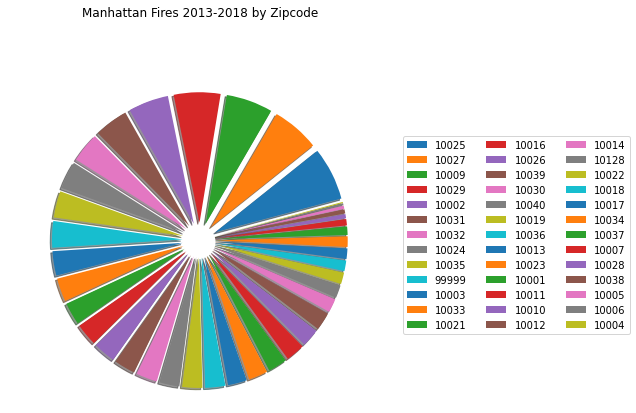

In [25]:
# Pie Chart - Manhattan
manhattan_labels = manhattan_df['ZIP_CODE'].value_counts().index.tolist()
manhattan_explode = [0.2] * len(manhattan_labels)
plt.pie(manhattan_df['ZIP_CODE'].value_counts(), labels=manhattan_labels, radius=1.5, shadow=True, 
textprops={'color':'w'}, explode=manhattan_explode, startangle=15)
plt.title('Manhattan Fires 2013-2018 by Zipcode', color='black', y=1.5)
plt.legend(manhattan_labels, bbox_to_anchor=(2.5, 1), ncol=3)
plt.show()

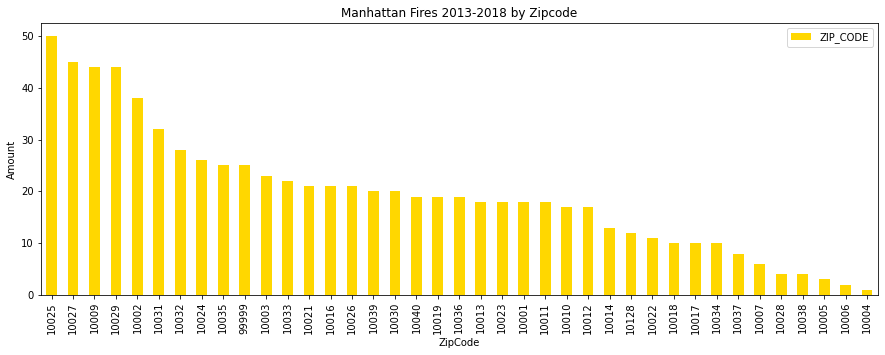

In [26]:
# Bar Graph - Manhattan
manhattan_df['ZIP_CODE'].value_counts().plot.bar(xlabel='ZipCode', ylabel='Amount', title='Manhattan Fires 2013-2018 by Zipcode', color='gold', figsize=(15,5))
plt.legend()
plt.show()

In [27]:
# Average Response time for Manhattan
manhattan_average = manhattan_df['RESPONSE_TIME'].mean()
manhattan_average.round(6)

4.11857

# Queens

In [28]:
# Create dataframe - Queens
queens_df = df[df['BOROUGH_DESC'] == '5 - Queens']
nomi = pgeocode.Nominatim('US')
queens_df.drop(['LATITUDE', 'LONGITUDE'], axis=1)
query = nomi.query_postal_code(queens_df['ZIP_CODE'].values)
queens_df['LATITUDE'] = query['latitude']
queens_df['LONGITUDE'] = query['longitude']
queens_df.dropna(subset=['LATITUDE'], inplace=True)
queens_df.dropna(subset=['LONGITUDE'], inplace=True)
queens_df

C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/4186980948.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  queens_df['LATITUDE'] = query['latitude']
C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/4186980948.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  queens_df['LONGITUDE'] = query['longitude']
C:\Users\Daiyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A v

,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,TOTAL_INCIDENT_DURATION,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,RESPONSE_TIME,LATITUDE,LONGITUDE
53,1380,"113 - Cooking fire, confined to container",2013-01-01 00:34:10,2013-01-01 00:37:52,3.0,01/01/2013 12:49:43 AM,933.0,BEACH 117 ST,11694,5 - Queens,3.70,40.7280,-73.8195
58,1201,"113 - Cooking fire, confined to container",2013-01-01 00:38:51,2013-01-01 00:42:40,6.0,01/01/2013 12:57:58 AM,1147.0,BEACHCHANNEL DR,11691,5 - Queens,3.82,40.7229,-73.8473
277,9353,131 - Passenger vehicle fire,2013-01-01 03:23:46,2013-01-01 03:30:46,2.0,01/01/2013 04:01:37 AM,2271.0,NORTHERN BLVD,11368,5 - Queens,7.00,40.6645,-73.7559
397,6086,131 - Passenger vehicle fire,2013-01-01 05:21:38,2013-01-01 05:25:59,2.0,01/01/2013 05:44:12 AM,1354.0,132 ST,11419,5 - Queens,4.35,40.6958,-73.7617
492,7973,111 - Building fire,2013-01-01 07:59:48,2013-01-01 08:03:33,6.0,01/01/2013 08:19:37 AM,1189.0,LAMONT AVE,11373,5 - Queens,3.75,40.7142,-73.7677
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38279,5857,"113 - Cooking fire, confined to container",2013-02-03 18:14:04,2013-02-03 18:18:14,2.0,02/03/2013 06:21:44 PM,460.0,137 AVE,11413,5 - Queens,4.17,40.6006,-73.7580
38303,4922,"113 - Cooking fire, confined to container",2013-02-03 18:34:56,2013-02-03 18:40:27,2.0,02/03/2013 06:49:24 PM,868.0,171 ST,11366,5 - Queens,5.52,40.7208,-73.7433
38419,7698,"113 - Cooking fire, confined to container",2013-02-03 20:43:03,2013-02-03 20:47:24,3.0,02/03/2013 08:58:15 PM,912.0,DITMARS BLVD,11369,5 - Queens,4.35,40.6769,-73.8448
38488,7358,"113 - Cooking fire, confined to container",2013-02-03 22:32:40,2013-02-03 22:36:13,6.0,02/03/2013 10:52:06 PM,1166.0,38 AVE,11101,5 - Queens,3.55,40.7374,-73.7951


In [29]:
# HeatMap with Markers of Zipcode locations and area frequency - Queens
queens = generate_map(default_loc=[40.7282, -73.7949] ,zoom=12, max_zoom=12, min_zoom=12, tiles='Stamen Terrain')
hm(data=queens_df[['LATITUDE', 'LONGITUDE']].groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist(), radius=7, max_zoom=10.5).add_to(queens)
for lat, long in zip(queens_df.LATITUDE, queens_df.LONGITUDE):
    folium.CircleMarker([lat, long], color='red').add_to(queens)
queens

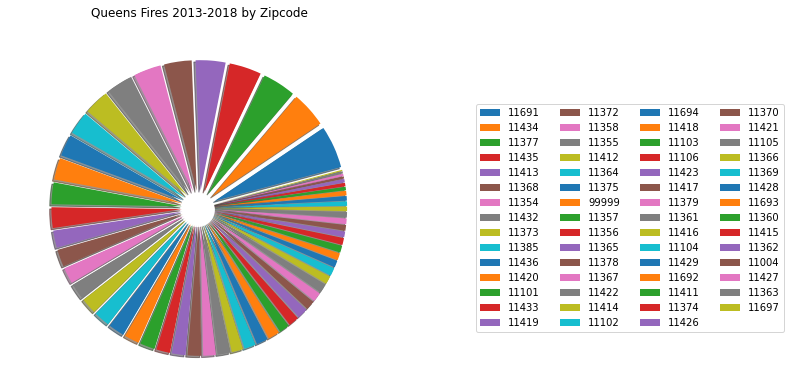

In [30]:
# Pie Chart - Queens
queens_labels = queens_df['ZIP_CODE'].value_counts().index.tolist()
queens_explode = [0.2] * len(queens_labels)
plt.pie(queens_df['ZIP_CODE'].value_counts(), labels=queens_labels, radius=1.5, shadow=True, 
textprops={'color':'w'}, explode=queens_explode, startangle=15)
plt.title('Queens Fires 2013-2018 by Zipcode', color='black', y=1.35)
plt.legend(queens_labels, bbox_to_anchor=(1.75, 1), ncol=4)
plt.show()

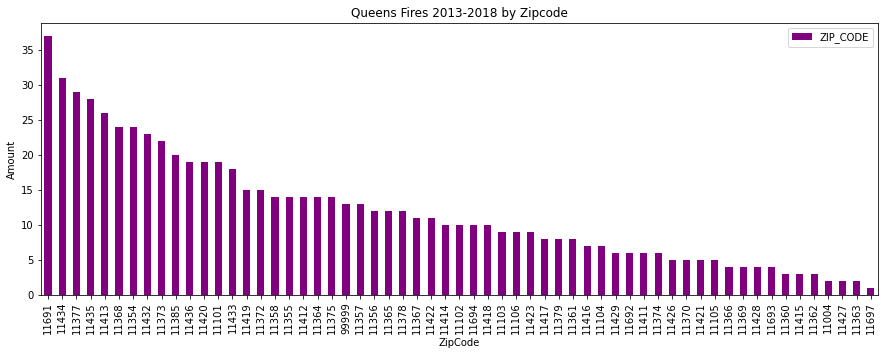

In [31]:
# Bar Graph - Queens
queens_df['ZIP_CODE'].value_counts().plot.bar(xlabel='ZipCode', ylabel='Amount', title='Queens Fires 2013-2018 by Zipcode', color='purple', figsize=(15,5))
plt.legend()
plt.show()

In [32]:
# Average Response time for Queens
queens_average = queens_df['RESPONSE_TIME'].mean()
queens_average.round(6)

4.33848

# Staten Island

In [33]:
# Create dataframe - Staten Island
si_df = df[df['BOROUGH_DESC'] == '3 - Staten Island']
nomi = pgeocode.Nominatim('US')
si_df.drop(['LATITUDE', 'LONGITUDE'], axis=1)
query = nomi.query_postal_code(si_df['ZIP_CODE'].values)
si_df['LATITUDE'] = query['latitude']
si_df['LONGITUDE'] = query['longitude']
si_df.dropna(subset=['LATITUDE'], inplace=True)
si_df.dropna(subset=['LONGITUDE'], inplace=True)
si_df

C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/1276343145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_df['LATITUDE'] = query['latitude']
C:\Users\Daiyan\AppData\Local\Temp/ipykernel_16012/1276343145.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_df['LONGITUDE'] = query['longitude']
C:\Users\Daiyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is 

,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,TOTAL_INCIDENT_DURATION,STREET_HIGHWAY,ZIP_CODE,BOROUGH_DESC,RESPONSE_TIME,LATITUDE,LONGITUDE
23,1949,"118 - Trash or rubbish fire, contained",2013-01-01 00:15:56,2013-01-01 00:20:17,1.0,01/01/2013 12:25:51 AM,595.0,ELSON CT,10314,3 - Staten Island,4.35,40.5352,-74.2116
118,3630,"151 - Outside rubbish, trash or waste fire",2013-01-01 01:23:11,2013-01-01 01:26:46,1.0,01/01/2013 01:31:15 AM,484.0,RYE AVE,10312,3 - Staten Island,3.58,40.6316,-74.0927
247,4755,"151 - Outside rubbish, trash or waste fire",2013-01-01 02:59:41,2013-01-01 03:06:09,2.0,01/01/2013 03:17:13 AM,1052.0,SIRTPLEASANTPLAINS,10309,3 - Staten Island,6.47,40.5518,-74.1526
1009,0397,"113 - Cooking fire, confined to container",2013-01-01 18:30:43,2013-01-01 18:33:45,6.0,01/01/2013 06:43:13 PM,750.0,HENDERSON AVE,10310,3 - Staten Island,3.03,40.6102,-74.0878
1016,0953,142 - Brush or brush-and-grass mixture fire,2013-01-01 18:37:16,2013-01-01 18:42:48,1.0,01/01/2013 06:44:40 PM,444.0,LAKE AVE,10303,3 - Staten Island,5.53,40.6316,-74.0927
1081,1034,"113 - Cooking fire, confined to container",2013-01-01 20:00:03,2013-01-01 20:02:53,6.0,01/01/2013 08:21:14 PM,1271.0,CLOVE RD,10304,3 - Staten Island,2.83,40.6102,-74.0878
1739,0752,"113 - Cooking fire, confined to container",2013-01-02 13:41:15,2013-01-02 13:45:22,2.0,01/02/2013 02:25:12 PM,2637.0,ALBION PL,10302,3 - Staten Island,4.12,40.6102,-74.0878
1851,0915,"113 - Cooking fire, confined to container",2013-01-02 15:24:58,2013-01-02 15:28:07,6.0,01/02/2013 03:45:37 PM,1239.0,JOHN ST,10302,3 - Staten Island,3.15,40.5457,-74.1792
2119,0577,"113 - Cooking fire, confined to container",2013-01-02 19:49:04,2013-01-02 19:53:18,2.0,01/02/2013 08:01:46 PM,762.0,COLLEGE AVE,10314,3 - Staten Island,4.23,40.6301,-74.1607
2155,2493,"113 - Cooking fire, confined to container",2013-01-02 20:22:52,2013-01-02 20:26:36,2.0,01/02/2013 08:30:16 PM,444.0,ST STEPHENS PL,10306,3 - Staten Island,3.73,40.6039,-74.1472


In [34]:
# HeatMap with Markers of Zipcode locations and area frequency - Staten Island
si = generate_map(default_loc=[40.5795, -74.1502] ,zoom=12, max_zoom=12, min_zoom=12, tiles='Stamen Terrain')
hm(data=si_df[['LATITUDE', 'LONGITUDE']].groupby(['LATITUDE', 'LONGITUDE']).sum().reset_index().values.tolist(), radius=7, max_zoom=10.5).add_to(si)
for lat, long in zip(si_df.LATITUDE, si_df.LONGITUDE):
    folium.CircleMarker([lat, long], color='red').add_to(si)
si

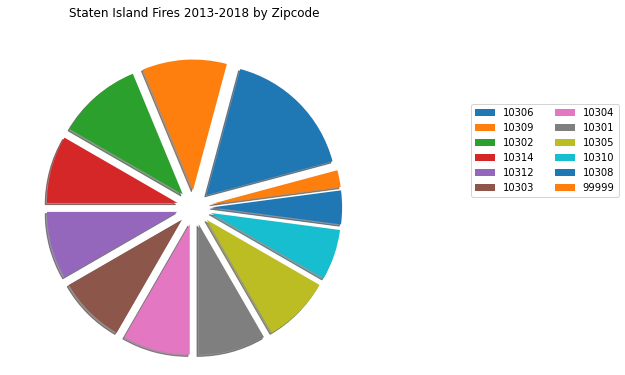

In [96]:
# Pie Chart - Staten Island
si_labels = si_df['ZIP_CODE'].value_counts().index.tolist()
si_explode = [0.2] * len(si_labels)
plt.pie(si_df['ZIP_CODE'].value_counts(), labels=si_labels, radius=1.5, shadow=True, 
textprops={'color':'w'}, explode=si_explode, startangle=15)
plt.title('Staten Island Fires 2013-2018 by Zipcode', color='black', y=1.35)
plt.legend(si_labels, bbox_to_anchor=(1.75, 1), ncol=2)
plt.show()

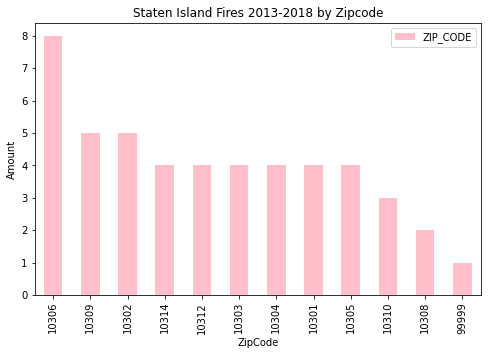

In [36]:
# Bar Graph - Staten Island
si_df['ZIP_CODE'].value_counts().plot.bar(xlabel='ZipCode', ylabel='Amount', title='Staten Island Fires 2013-2018 by Zipcode', color='pink', figsize=(8,5))
plt.legend()
plt.show()

In [37]:
# Average Response time for Staten Island
si_average = si_df['RESPONSE_TIME'].mean()
si_average.round(6)

4.538333

# Average Fire Response Times by Borough

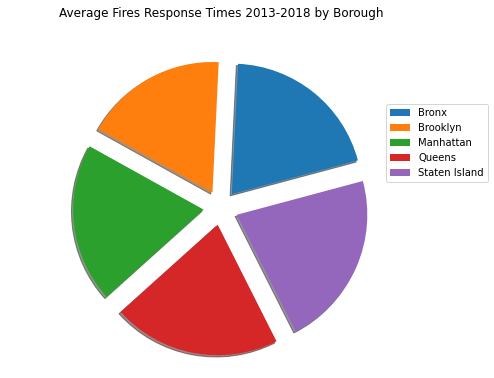

In [98]:
# Pie Chart - Average
avg_labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
avg_values = [bronx_average, brooklyn_average, manhattan_average, queens_average, si_average]
avg_explode = [0.2] * len(avg_labels)
plt.pie(avg_values, labels=avg_labels, radius=1.5, shadow=True, 
textprops={'color':'w'}, explode=avg_explode, startangle=15)
plt.title('Average Fires Response Times 2013-2018 by Borough', color='black', y=1.35)
plt.legend(avg_labels, bbox_to_anchor=(1.75, 1), ncol=1)
plt.show()

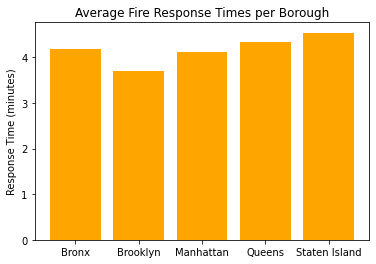

In [39]:
# Average Fires Bar Plot
plt.bar(avg_labels, avg_values, color='orange')
plt.title('Average Fire Response Times per Borough')
plt.ylabel('Response Time (minutes)')
plt.show()